# Assay Annotations
This notebook explores and compares the annotation data for two different sets of assays from PubChem.

Run `pubchem_assay_annotations.py` on each .aid file BEFORE using this notebook to get the required input files (assay ids with annotation info).

## Define path to inputs
In this case, all variables with "_1" (original) correspond to assay IDs from the original badapple DB, whereas variables with "_2" (new) are from applying the following filters to all assays in PubChem, as of 9/25/2024:
1) N_compounds_tested >= 20,000
2) Data source category from "NIH Initiatives"
3) Assay outcome type is one of "Screening", "Confirmatory", or "Other" (same as badapple)

In [1]:
# run pubchem_assay_annotations.py to generate these files
ANNOTATIONS_JSON_FILE_1 = "/media/jack/big_disk/data/badapple/assay_annotations_tested.json"
ANNOTATIONS_JSON_FILE_2 = "/media/jack/big_disk/data/badapple/assays/assay_annotations_hts_20000.json"

## Setup

In [2]:
import json
import matplotlib.pyplot as plt
from collections import Counter
import pandas as pd

In [3]:
def load_json_file(json_file: str):
    with open(json_file, "r") as f:
        data = json.load(f)
    return data

In [4]:
# load data
ann_data_1 = load_json_file(ANNOTATIONS_JSON_FILE_1)
ann_data_2 = load_json_file(ANNOTATIONS_JSON_FILE_2)

In [5]:
assay_ids_1 = set(ann_data_1["Annotations"].keys())
assay_ids_2 = set(ann_data_2["Annotations"].keys())
n_assays_1 = len(assay_ids_1)
n_assays_2 = len(assay_ids_2)
expected_diff_total = len(assay_ids_2 - assay_ids_1)
print("Total number of assays from original:", n_assays_1)
print("Total number of assays from new:", n_assays_2)
print("Assays in original not in new:", len(assay_ids_1 - assay_ids_2))
print("Assays in new not in original:", len(assay_ids_2 - assay_ids_1))

Total number of assays from original: 823
Total number of assays from new: 906
Assays in original not in new: 0
Assays in new not in original: 83


### Shared Function Definitions

In [6]:
def get_source_ref_num(aid_ref_list: list[dict], source: str) -> int:
    for ref in aid_ref_list:
        if "SourceName" in ref and ref["SourceName"] == source:
            return ref["ReferenceNumber"]
    return -1

In [7]:
def get_source_annotations(ann_data: dict[str, dict], aid_2_sourcerefnum: dict, source_annotation_types: list[str]) -> dict[str, list[str]]:
    source_annotations = {ann_name: [] for ann_name in source_annotation_types}
    for aid, ref_n in aid_2_sourcerefnum.items():
        if ref_n == -1:
            # AID not in source
            # add "UNKNOWN" for entries not in source
            for ann_name in source_annotation_types:
                source_annotations[ann_name].append("UNKNOWN")
        else:
            # AID has entry in source
            aid_annotations = ann_data["Annotations"][aid]
            remaining_terms = source_annotation_types.copy()
            for annotation in aid_annotations:
                if annotation["ReferenceNumber"] == ref_n:
                    ann_name = annotation["Name"]
                    ann_val = annotation["Value"]
                    if ann_name in source_annotations:
                        source_annotations[ann_name].append(ann_val)
                    else:
                        source_annotations[ann_name] = [ann_val]
                    remaining_terms.remove(ann_name)
            # add "NULL" for partially-labeled entries
            for ann_name in remaining_terms:
                source_annotations[ann_name].append("NULL")
    return source_annotations

In [8]:
def get_frequency_df(d: dict[str, list[str]], key: str) -> pd.DataFrame:
    term_counts = Counter(d[key])
    df = pd.DataFrame(term_counts.items(), columns=['Term', 'Frequency'])
    df = df.sort_values(by='Frequency', ascending=False).reset_index(drop=True)
    return df

In [9]:
def get_high_frequency_df(df: pd.DataFrame, thresh: int, freq_col: str = "Frequency") -> pd.DataFrame:
    # group terms with frequencies <= thresh under "Other" category
    df_high_freq = df[df[freq_col] > thresh]
    other_freq_sum = df[df[freq_col] <= thresh][freq_col].sum()
    i = len(df_high_freq)
    df_high_freq.loc[i] = ['OTHER', other_freq_sum]
    df_high_freq = df_high_freq.sort_values(by=freq_col, ascending=False).reset_index(drop=True)
    return df_high_freq

In [10]:
def plot_term_counts(frequency_df: pd.DataFrame, key: str, expected_assays: int, freq_col: str = 'Frequency', use_log: bool = True):
    n_total = sum(frequency_df[freq_col])
    assert n_total == expected_assays, n_total

    plt.figure(figsize=(10, 6))
    plt.bar(frequency_df['Term'], frequency_df[freq_col], color='skyblue')

    plt.xlabel('Terms')
    plt.ylabel(freq_col)
    if use_log:
        plt.yscale('log')
    plt.title(f'Frequency of {key} Terms, N={n_total}')
    plt.xticks(rotation=45, ha='right')

    plt.tight_layout()
    plt.show()

In [11]:
def plot_comparison_bar(df: pd.DataFrame, freq_col_1: str, freq_col_2: str,):
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.bar(df['Term'], df[freq_col_1], width=0.35, label=freq_col_1, color='skyblue', align="center")
    ax.bar(df['Term'], df[freq_col_2], width=0.35/3, label=freq_col_2, color='orange', align="center")

    # Add labels and title
    ax.set_xlabel('Term')
    ax.set_yscale("log")
    ax.set_ylabel('Frequency')
    ax.set_title(f'Comparison of {freq_col_1} and {freq_col_2}')
    ax.legend()

    # Rotate x-axis labels for better readability
    plt.xticks(rotation=45, ha='right')

    # Show plot
    plt.tight_layout()
    plt.show()

In [12]:
def get_annotation_dfs(ann_data: dict[str, dict], source_name: str, annotation_types: list[str]):
    aid_2_refnum = {}
    for aid in ann_data["References"]:
        aid_2_refnum[aid] = get_source_ref_num(ann_data["References"][aid], source_name)
    # for each annotation type store a list of all the terms
    source_annotations = get_source_annotations(ann_data, aid_2_refnum, annotation_types)
    assert list(source_annotations.keys()) == annotation_types, f"keys: {source_annotations.keys()}\ntypes: {annotation_types}"
    # get term frequency dataframes 
    source_annotation_2_df = {}
    for ann_name in source_annotations.keys():
        source_annotation_2_df[ann_name] = get_frequency_df(source_annotations, ann_name)
    return source_annotation_2_df


In [13]:
def get_merged_freq_df(df_set_1: dict[str, pd.DataFrame], df_set_2: dict[str, pd.DataFrame], annotation_type: str):
    annotation_merged_df = pd.merge(df_set_1[annotation_type], df_set_2[annotation_type], on='Term')
    annotation_merged_df.rename(columns={"Frequency_x": "Frequency_OG", "Frequency_y": "Frequency_NEW"}, inplace=True)
    annotation_merged_df["Frequency_Diff"] = annotation_merged_df["Frequency_NEW"] - annotation_merged_df["Frequency_OG"]
    return annotation_merged_df

## Visualizing annotations from BARD

In [14]:
BARD_ANNOTATION_TYPES = ['Assay Format', 'Assay Type', 'Detection Method']

In [15]:
bard_annotation_2_df_1 = get_annotation_dfs(ann_data_1, "BioAssay Research Database (BARD)", BARD_ANNOTATION_TYPES)
bard_annotation_2_df_2 = get_annotation_dfs(ann_data_2, "BioAssay Research Database (BARD)", BARD_ANNOTATION_TYPES)

### Assay Format

In [16]:
ANNOTATION_TYPE = "Assay Format"

In [17]:
# remove redundant substr "format"
bard_annotation_2_df_1[ANNOTATION_TYPE]["Term"] = bard_annotation_2_df_1['Assay Format']["Term"].map(lambda x: x.replace(' format', ''))
bard_annotation_2_df_2[ANNOTATION_TYPE]["Term"] = bard_annotation_2_df_2["Assay Format"]["Term"].map(lambda x: x.replace(' format', ''))

In [18]:
# since set 2 is a superset of set 1, can just use subtraction
annotation_merged_df = get_merged_freq_df(bard_annotation_2_df_1, bard_annotation_2_df_2, ANNOTATION_TYPE)

In [19]:
annotation_merged_df

,Term,Frequency_OG,Frequency_NEW,Frequency_Diff
0,cell-based,319,331,12
1,UNKNOWN,155,220,65
2,single protein,89,94,5
3,biochemical,87,88,1
4,protein,84,84,0
5,protein complex,44,44,0
6,organism-based,17,17,0
7,small-molecule,14,14,0
8,nucleic acid,5,5,0
9,whole-cell lysate,3,3,0


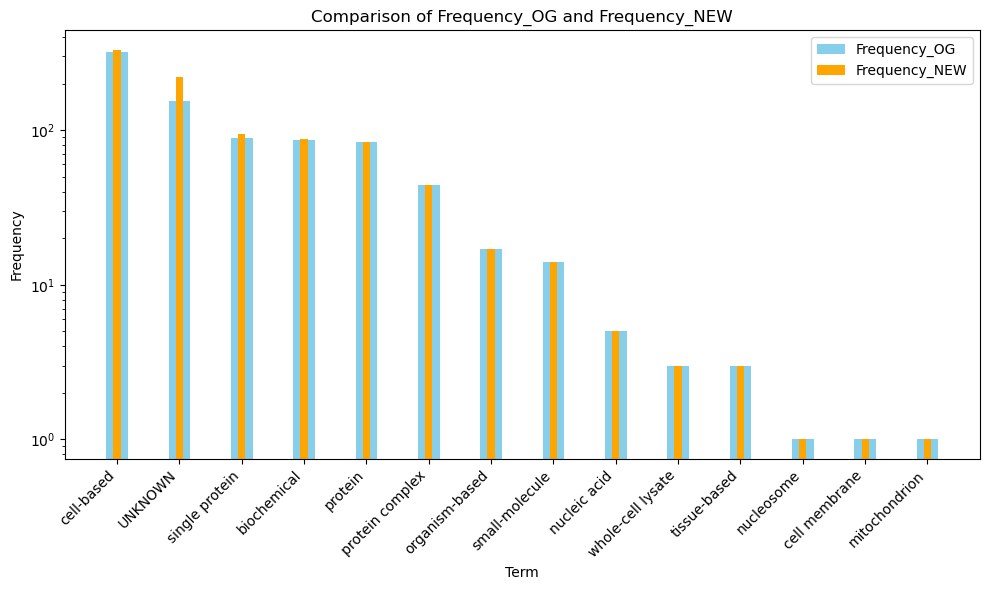

In [20]:
# show both original (OG) and new term counts
plot_comparison_bar(annotation_merged_df, "Frequency_OG", "Frequency_NEW")

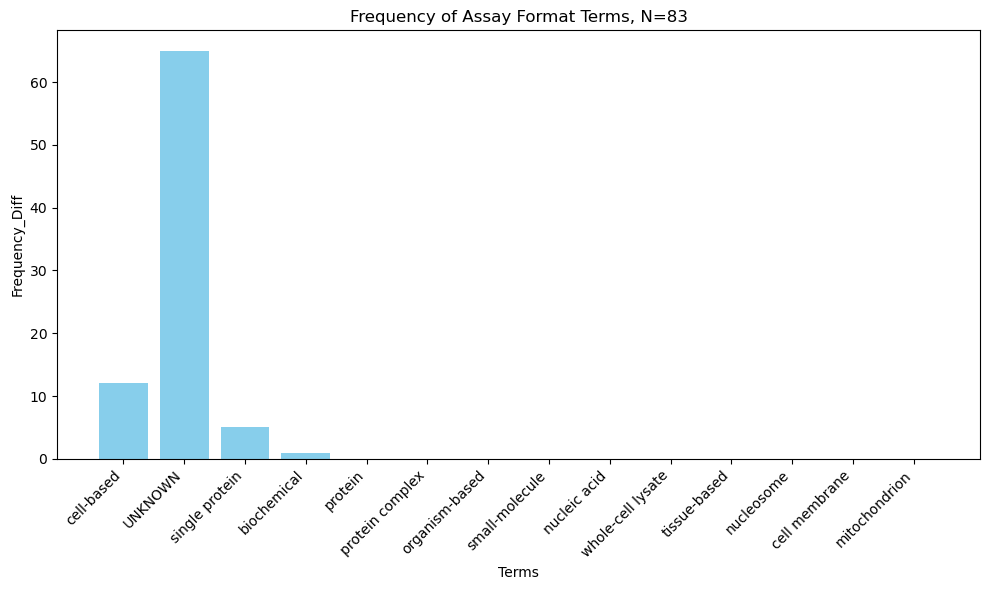

In [21]:
# show difference
plot_term_counts(annotation_merged_df, ANNOTATION_TYPE, expected_diff_total, "Frequency_Diff", use_log=False)

### Assay Type

In [22]:
ANNOTATION_TYPE = "Assay Type"

In [23]:
bard_annotation_2_df_1[ANNOTATION_TYPE]["Term"] = bard_annotation_2_df_1[ANNOTATION_TYPE]["Term"].map(lambda x: x.replace(' assay', ''))
bard_annotation_2_df_2[ANNOTATION_TYPE]["Term"] = bard_annotation_2_df_2[ANNOTATION_TYPE]["Term"].map(lambda x: x.replace(' assay', ''))

In [24]:
annotation_merged_df = get_merged_freq_df(bard_annotation_2_df_1, bard_annotation_2_df_2, ANNOTATION_TYPE)

In [25]:
annotation_merged_df

,Term,Frequency_OG,Frequency_NEW,Frequency_Diff
0,UNKNOWN,155,220,65
1,protein-small molecule interaction,120,121,1
2,direct enzyme activity,103,105,2
3,protein-protein interaction,80,80,0
4,reporter-gene,71,74,3
5,coupled enzyme activity,36,39,3
6,cytotoxicity,34,36,2
7,enzyme activity,33,33,0
8,protein expression,17,17,0
9,ion-channel,16,16,0


In [26]:
# for the sake of plotting, group together terms which occur <= 5 times
bard_annotation_2_df_1[ANNOTATION_TYPE] = get_high_frequency_df(bard_annotation_2_df_1[ANNOTATION_TYPE], 5)
bard_annotation_2_df_2[ANNOTATION_TYPE] = get_high_frequency_df(bard_annotation_2_df_2[ANNOTATION_TYPE], 5)
annotation_merged_df = annotation_merged_df = get_merged_freq_df(bard_annotation_2_df_1, bard_annotation_2_df_2, ANNOTATION_TYPE)

/tmp/ipykernel_113649/2689725211.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_high_freq.loc[i] = ['OTHER', other_freq_sum]
/tmp/ipykernel_113649/2689725211.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_high_freq.loc[i] = ['OTHER', other_freq_sum]


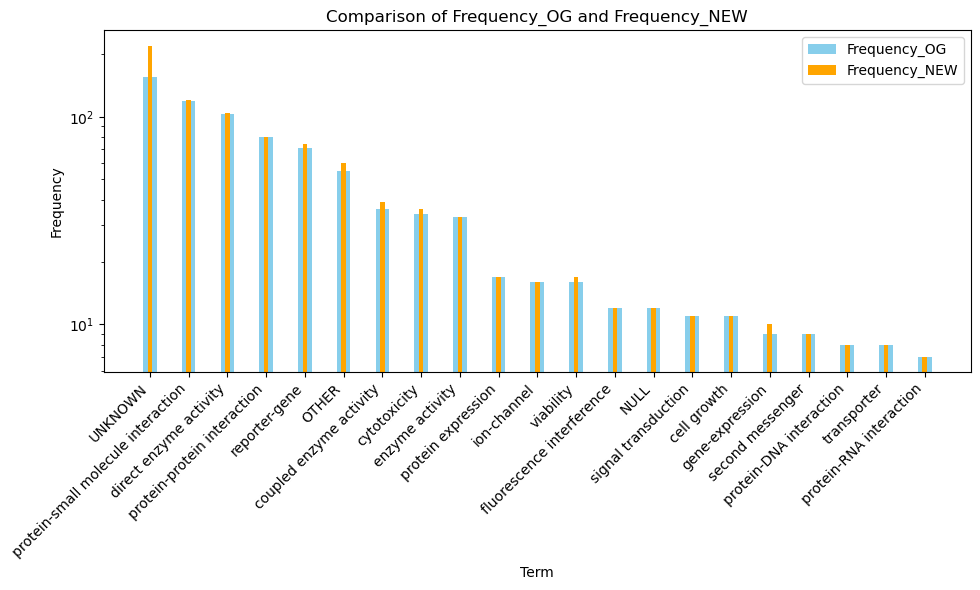

In [27]:
# show both original (OG) and new term counts
plot_comparison_bar(annotation_merged_df, "Frequency_OG", "Frequency_NEW")


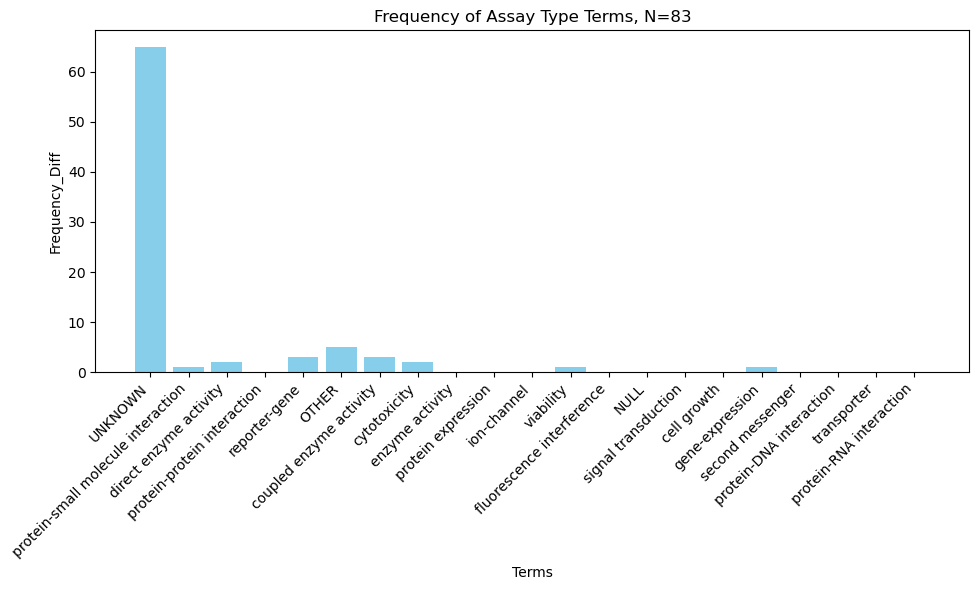

In [28]:
# show difference
plot_term_counts(annotation_merged_df, ANNOTATION_TYPE, expected_diff_total, "Frequency_Diff", use_log=False)

### Detection Method

In [29]:
ANNOTATION_TYPE = "Detection Method"

In [30]:
bard_annotation_2_df_1[ANNOTATION_TYPE]["Term"] = bard_annotation_2_df_1[ANNOTATION_TYPE]["Term"].map(lambda x: x.replace(' assay', ''))
bard_annotation_2_df_2[ANNOTATION_TYPE]["Term"] = bard_annotation_2_df_2[ANNOTATION_TYPE]["Term"].map(lambda x: x.replace(' assay', ''))

In [31]:
annotation_merged_df = get_merged_freq_df(bard_annotation_2_df_1, bard_annotation_2_df_2, ANNOTATION_TYPE)

In [32]:
annotation_merged_df

,Term,Frequency_OG,Frequency_NEW,Frequency_Diff
0,fluorescence intensity,219,225,6
1,UNKNOWN,155,220,65
2,bioluminescence,84,90,6
3,fluorescence polarization,63,63,0
4,luminescence method,63,65,2
5,fluorescence method,50,50,0
6,chemiluminescence,46,47,1
7,fluorescence resonance energy transfer,38,38,0
8,absorbance,35,36,1
9,flow cytometry,14,14,0


In [33]:
# for the sake of plotting, group together terms which occur <= 5 times
bard_annotation_2_df_1[ANNOTATION_TYPE] = get_high_frequency_df(bard_annotation_2_df_1[ANNOTATION_TYPE], 5)
bard_annotation_2_df_2[ANNOTATION_TYPE] = get_high_frequency_df(bard_annotation_2_df_2[ANNOTATION_TYPE], 5)
annotation_merged_df = annotation_merged_df = get_merged_freq_df(bard_annotation_2_df_1, bard_annotation_2_df_2, ANNOTATION_TYPE)

/tmp/ipykernel_113649/2689725211.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_high_freq.loc[i] = ['OTHER', other_freq_sum]
/tmp/ipykernel_113649/2689725211.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_high_freq.loc[i] = ['OTHER', other_freq_sum]


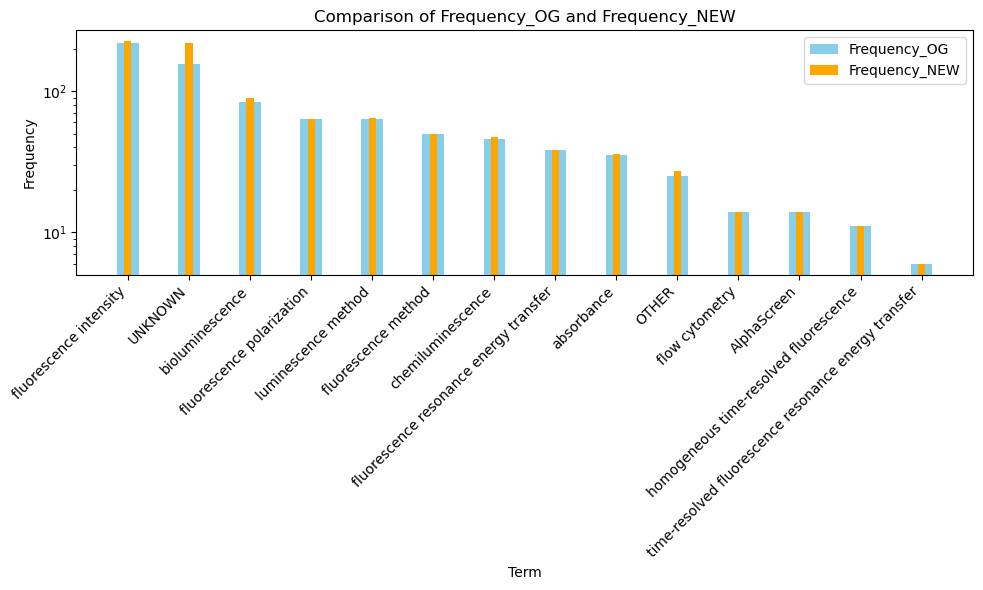

In [34]:
# show both original (OG) and new term counts
plot_comparison_bar(annotation_merged_df, "Frequency_OG", "Frequency_NEW")


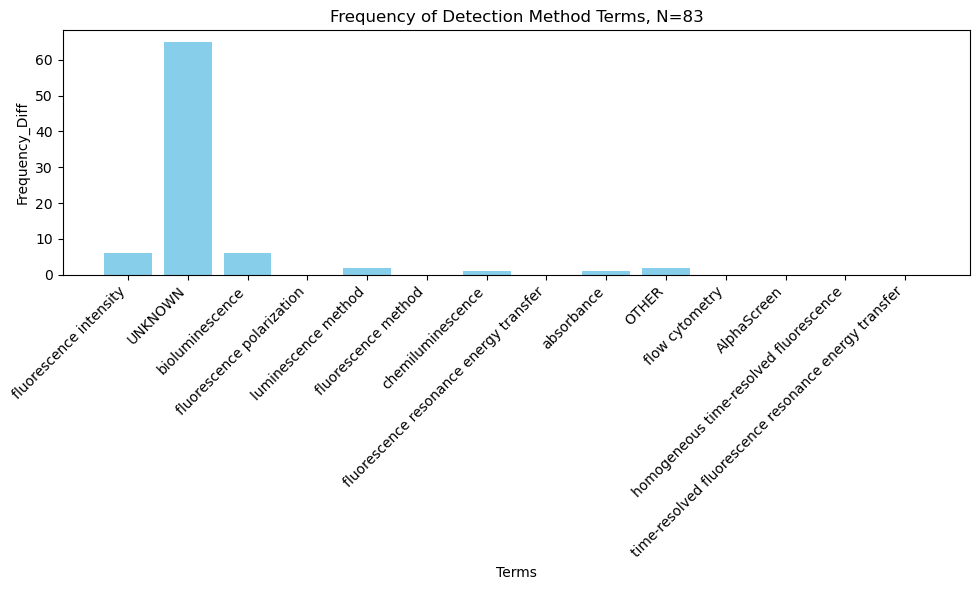

In [35]:
# show difference
plot_term_counts(annotation_merged_df, ANNOTATION_TYPE, expected_diff_total, "Frequency_Diff", use_log=False)

## Annotations from ChEMBL
Note: ChEMBL annotations not available for a large majority of assays, so not bothering with bar plots for this section.

In [36]:
ChEMBL_ANNOTATION_TYPES = ['Assay Type', 'Assay Organism', 'Assay Format', 'Assay Cell Type', 'Assay Strain']

In [37]:
chembl_annotation_2_df_1 = get_annotation_dfs(ann_data_1, "ChEMBL", ChEMBL_ANNOTATION_TYPES)
chembl_annotation_2_df_2 = get_annotation_dfs(ann_data_2, "ChEMBL", ChEMBL_ANNOTATION_TYPES)

### Assay Format

In [38]:
ANNOTATION_TYPE = "Assay Format"
freq_df = get_merged_freq_df(chembl_annotation_2_df_1, chembl_annotation_2_df_2, ANNOTATION_TYPE)
freq_df

,Term,Frequency_OG,Frequency_NEW,Frequency_Diff
0,UNKNOWN,603,684,81
1,NULL,204,205,1
2,Cell-based,13,14,1
3,Organism-based,3,3,0


### Assay Type

In [39]:
ANNOTATION_TYPE = "Assay Type"
freq_df = get_merged_freq_df(chembl_annotation_2_df_1, chembl_annotation_2_df_2, ANNOTATION_TYPE)
freq_df

,Term,Frequency_OG,Frequency_NEW,Frequency_Diff
0,UNKNOWN,603,684,81
1,Functional,193,195,2
2,Binding,27,27,0


### Assay Strain

In [40]:
ANNOTATION_TYPE = "Assay Strain"
freq_df = get_merged_freq_df(chembl_annotation_2_df_1, chembl_annotation_2_df_2, ANNOTATION_TYPE)
freq_df

,Term,Frequency_OG,Frequency_NEW,Frequency_Diff
0,UNKNOWN,603,684,81
1,NULL,218,220,2
2,3D7,2,2,0


### Assay Organism

In [41]:
ANNOTATION_TYPE = "Assay Organism"
freq_df = get_merged_freq_df(chembl_annotation_2_df_1, chembl_annotation_2_df_2, ANNOTATION_TYPE)
freq_df

,Term,Frequency_OG,Frequency_NEW,Frequency_Diff
0,UNKNOWN,603,684,81
1,Homo sapiens,113,114,1
2,NULL,67,68,1
3,Mus musculus,7,7,0
4,Rattus norvegicus,4,4,0
5,Trypanosoma cruzi,2,2,0
6,Plasmodium falciparum,2,2,0
7,Human immunodeficiency virus 1,2,2,0
8,Chlorocebus sabaeus,2,2,0
9,Bacillus subtilis,2,2,0


### Assay Cell Type

In [42]:
ANNOTATION_TYPE = "Assay Cell Type"
freq_df = get_merged_freq_df(chembl_annotation_2_df_1, chembl_annotation_2_df_2, ANNOTATION_TYPE)
freq_df

,Term,Frequency_OG,Frequency_NEW,Frequency_Diff
0,UNKNOWN,603,684,81
1,NULL,210,212,2
2,HEK293,2,2,0
3,Vero,2,2,0
4,HT-1080,1,1,0
5,MIN6,1,1,0
6,HeLa,1,1,0
7,T-cell,1,1,0
8,HepG2,1,1,0
9,SW480,1,1,0
